                    ----- MADRS prediction 16h segments -----

Importing libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix 
from sklearn.metrics import mean_squared_error

import os
import sys
import random

from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD, Nadam, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.models import Sequential, load_model

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras import optimizers

import math

In [2]:
# hyperparameters

step = 60 
batch_size = 16
optimizer = optimizers.Adam(lr = 0.00001) # learning rate is very low, otherwise the gradients exploded
verbose = 1
data_dir = "Downloads/depression_data"
segment_length = 960
learning_rate = 0.0001

Function for creating the segments and corresponding labels for MADRS prediction
 - it will read scores.csv (with all the demographics etc), and generates:
     -> one list of time sliced sequences
     -> one list of the corresponding participants' labels (madrs scores)

In [3]:
def segments_and_labels(dataset_dir, segment_length, step):
    scores = pd.read_csv(os.path.join(dataset_dir, 'scores.csv'))
    scores['madrs2'].fillna(0, inplace=True)

    segments = []
    labels = []

    for person in scores['number']:
        p = scores[scores['number'] == person]
        filepath = os.path.join(dataset_dir, person.split('_')[0], f'{person}.csv')
        df_activity = pd.read_csv(filepath)

        for i in range(0, len(df_activity) - segment_length, step):
            segment = df_activity['activity'].values[i : i + segment_length]
            
            segments.append([segment])
            labels.append(p['madrs2'].values[0])

    segments = np.asarray(segments)
    segments = segments.reshape(-1, segment_length, 1)

    input_shape = segments.shape[1]
    segments = segments.reshape(segments.shape[0], input_shape).astype('float32')
    labels = np.asarray(labels).astype('float32')

    return segments, labels, input_shape

print(segments_and_labels(data_dir,segment_length,step))

(array([[  0., 143.,   0., ...,   0.,   0.,   0.],
       [306., 286.,  12., ...,   0.,   0.,   0.],
       [  0.,   0.,  21., ...,   0.,   0.,   9.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]], dtype=float32), array([19., 19., 19., ...,  0.,  0.,  0.], dtype=float32), 960)


Splitting dataset, later I will add a validation set as well

In [54]:
segments, labels, input_shape = segments_and_labels(data_dir,segment_length,step)

X_train, X_test, y_train, y_test = train_test_split(segments, labels, test_size=0.2, random_state=777)
print(X_train.shape)
print()
print(X_test.shape)
print()
print(y_train.shape)
print()
print(y_test.shape)

(20272, 960)

(5069, 960)

(20272,)

(5069,)


Normalization

In [55]:
sc = MinMaxScaler(feature_range = (0,1))
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.fit_transform(X_test)
y_train_scaled = sc.fit_transform(y_train.reshape(-1,1))
y_test_scaled = sc.fit_transform(y_test.reshape(-1,1))

print(X_train_scaled.shape)
print()
print(X_test_scaled.shape)
print()
print(y_train_scaled.shape)
print()
print(y_test_scaled.shape)

(20272, 960)

(5069, 960)

(20272, 1)

(5069, 1)


Reshaping, otherwise it won't fit in the LSTM model

In [59]:
X_train_scaled_res = np.reshape(X_train_scaled, (X_train_scaled.shape[0], X_train_scaled.shape[1], 1))

y_train_scaled_res = np.reshape(y_train_scaled, (y_train_scaled.shape[0], y_train_scaled.shape[1], 1))

X_test_scaled_res = np.reshape(X_test_scaled, (X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

y_test_scaled_res = np.reshape(y_test_scaled, (y_test_scaled.shape[0], y_test_scaled.shape[1], 1))

print(X_train_scaled_res.shape)
print()
print(y_train_scaled_res.shape)
print()
print(X_test_scaled_res.shape)
print()
print(y_test_scaled_res.shape)

(20272, 960, 1)

(20272, 1, 1)

(5069, 960, 1)

(5069, 1, 1)


Building LSTM model

In [20]:
def build_model():
    model = Sequential()
    model.add(LSTM(units = 30, return_sequences = True, input_shape = (X_train_scaled.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 30, return_sequences = True, activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 30, return_sequences = True, activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 30))
    model.add(Dropout(0.2))
    model.add(Dense(1, kernel_initializer='lecun_normal', activation='linear'))
    model.compile(optimizer = optimizer, 
                  loss = 'mean_squared_error', 
                  metrics = [tf.keras.metrics.RootMeanSquaredError()])
    
    return model

Cross-validation + validation samples

In [21]:
train_data = X_train_scaled_res
train_targets = y_train_scaled_res
k = 3
num_val_samples = len(train_data) // k
num_epochs = 4
all_scores = [] # Should add the score of each run at the end of the loop
all_mae_histories = []
val_all_mae_histories = []

for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model 
    model = build_model()
    # Train the model 
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=batch_size, verbose=1)
    mae_history = history.history['root_mean_squared_error']
    all_mae_histories.append(mae_history)
    val_mae_history = history.history['val_root_mean_squared_error']
    val_all_mae_histories.append(val_mae_history)
    
    # Evaluate the model on the validation data
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

processing fold # 0
Epoch 1/4
845/845 [==============================] - 641s 753ms/step - loss: 0.1533 - root_mean_squared_error: 0.3908 - val_loss: 0.1206 - val_root_mean_squared_error: 0.3473
Epoch 2/4
845/845 [==============================] - 657s 778ms/step - loss: 0.1220 - root_mean_squared_error: 0.3492 - val_loss: 0.1206 - val_root_mean_squared_error: 0.3473
Epoch 3/4
845/845 [==============================] - 5898s 7s/step - loss: 0.1210 - root_mean_squared_error: 0.3478 - val_loss: 0.1209 - val_root_mean_squared_error: 0.3477
Epoch 4/4
845/845 [==============================] - 700s 828ms/step - loss: 0.1238 - root_mean_squared_error: 0.3518 - val_loss: 0.1203 - val_root_mean_squared_error: 0.3468
processing fold # 1
Epoch 1/4
845/845 [==============================] - 709s 834ms/step - loss: 0.1481 - root_mean_squared_error: 0.3843 - val_loss: 0.1215 - val_root_mean_squared_error: 0.3485
Epoch 2/4
845/845 [==============================] - 2201s 3s/step - loss: 0.1219 - roo

Training and validation results of 16h segment LSTM MODEL

In [30]:
print("RMSE of fold 1, 2 and 3:\n")
print(all_scores)
print()
print("Mean RMSE of all folds:\n")
print(np.mean(all_scores))

RMSE of fold 1, 2 and 3:

[0.3468414843082428, 0.3481077253818512, 0.34987521171569824]

Mean RMSE of all folds:

0.3482748071352641


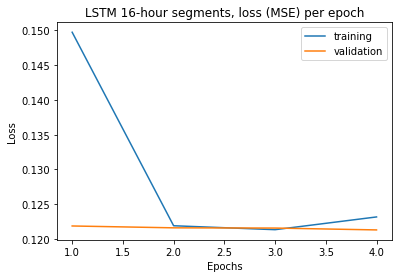

In [122]:
average_loss = [0.149733333,0.12190000000000001,0.12133333333333333,0.12316666666666666]
average_val_loss = [0.12186666666666666,0.1216,0.12156666666666666,0.1213]

plt.plot(range(1, len(average_loss) + 1), average_loss)
plt.plot(range(1, len(average_val_loss) + 1), average_val_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['training', 'validation'])
plt.title('LSTM 16-hour segments, loss (MSE) per epoch')
plt.savefig('LSTM_pred_16h_MSE.png')
plt.show()

In [ ]:
fig = plt.figure()
ax = fig.add_axes([1,1,1,1])
ax.plot([1,2])

fig.savefig('test.png')


Average per-epoch RMSE for all folds

In [31]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]
val_average_mae_history = [
    np.mean([x[i] for x in val_all_mae_histories]) for i in range(num_epochs)]

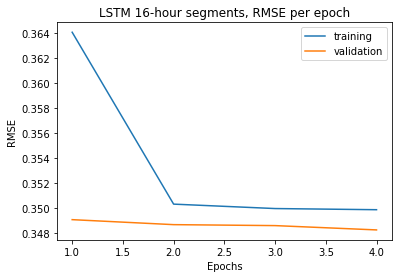

In [92]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history)+ 1), average_mae_history)
plt.plot(range(1, len(val_average_mae_history)+ 1), val_average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend(['training', 'validation'])
plt.title('LSTM 16-hour segments, RMSE per epoch')
plt.show()

In [125]:
print(average_mae_history)
print(val_average_mae_history)

[0.364083727200826, 0.35033705830574036, 0.3499833544095357, 0.34989064931869507]
[0.3490954339504242, 0.34869622190793353, 0.34861963987350464, 0.34827475746472675]


Training final model on all of the training data and evaluate on test set

In [94]:
test_data = X_test_scaled_res 
test_targets = y_test_scaled_res

In [96]:
# Get a fresh, compiled model.
model = build_model()
# Train it on the entirety of the data.
history_test = model.fit(train_data, train_targets,
                        epochs=12, batch_size=16, verbose=1)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

Epoch 1/12
1267/1267 [==============================] - 661s 519ms/step - loss: 0.1461 - root_mean_squared_error: 0.3816
Epoch 2/12
1267/1267 [==============================] - 672s 530ms/step - loss: 0.1240 - root_mean_squared_error: 0.3522
Epoch 3/12
1267/1267 [==============================] - 683s 539ms/step - loss: 0.1212 - root_mean_squared_error: 0.3481
Epoch 4/12
1267/1267 [==============================] - 683s 539ms/step - loss: 0.1213 - root_mean_squared_error: 0.3483
Epoch 5/12
1267/1267 [==============================] - 681s 537ms/step - loss: 0.1224 - root_mean_squared_error: 0.3499
Epoch 6/12
1267/1267 [==============================] - 682s 538ms/step - loss: 0.1237 - root_mean_squared_error: 0.3516
Epoch 7/12
1267/1267 [==============================] - 682s 538ms/step - loss: 0.1229 - root_mean_squared_error: 0.3505
Epoch 8/12
1267/1267 [==============================] - 681s 538ms/step - loss: 0.1230 - root_mean_squared_error: 0.3507
Epoch 9/12
1267/1267 [==========

In [113]:
print("Average Mean Squared Error:\n")
print(test_mse_score)
print()
print("Average Root Mean Squared Error:\n")
print(test_mae_score)

Average Mean Squared Error:

0.12440933287143707

Average Root Mean Squared Error:

0.3527170717716217


Testing model on test set

In [108]:
model_16h_predict = model.predict(X_test_scaled_res, verbose = 1)
model_16h_predict = sc.inverse_transform(model_16h_predict)
print(model_16h_predict)
y_test_inversed = (sc.inverse_transform(y_test_scaled))

159/159 [==============================] - 25s 159ms/step
[[6.920688 ]
 [6.7031264]
 [7.347808 ]
 ...
 [6.558285 ]
 [7.347761 ]
 [7.345595 ]]


In [110]:
y_actual = y_test_inversed
y_predicted = model_16h_predict
 
MSE = mean_squared_error(y_actual, y_predicted)

#print(mean_absolute_error(y_actual, y_predicted))
print("Mean Squared Error:\n")
print(MSE)
print()
RMSE = math.sqrt(MSE)
print("Root Mean Squared Error:\n")
print(RMSE)

Mean Squared Error:

97.53688

Root Mean Squared Error:

9.876076168862006
